# End-to-end Multi-class Dog Breed Classification Using Deep Learning
This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub to classify images of different dog breeds. The dataset used is the Stanford Dogs Dataset, which contains images of 120 different dog breeds.

## 1. Problem Definition
The goal is to create a deep learning model that can accurately classify images of dogs into their respective breeds.
## 2. Data
The Stanford Dogs Dataset can be downloaded from Kaggle's dog breed identification competition [here](https://www.kaggle.com/competitions/dog-breed-identification/overview). It contains over 20,000 images of dogs from 120 different breeds.
## 3. Evaluation Metric
The evaluation is a file with prediction probabilities for each breed for each image in the test set. Submissions are evaluated on Multi Class Log Loss between the predicted probability and the observed target.
## 4. Features
Some information about the data: 
* We're dealing with images (unstructured data) so it's  probably best we use deep learning/transfer learning.
* There are 10,000+ images in the training set (with labels) and 10,000+ images in the test set (without labels).

### Get out workspace ready
* Import TensorFlow 2.x ✅
* Import TensorFlow hub ✅
* Make sure we're using a GPU ✅

In [32]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

# Verify TensorFlow version
print("TensorFlow version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.16.2
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Getting our data ready (turning into tensors)
With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. We'll be using the `ImageDataGenerator` class from `tensorflow.keras.preprocessing.image` to load in our images from directories and turn them into tensors.

In [33]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


In [34]:
labels_csv["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

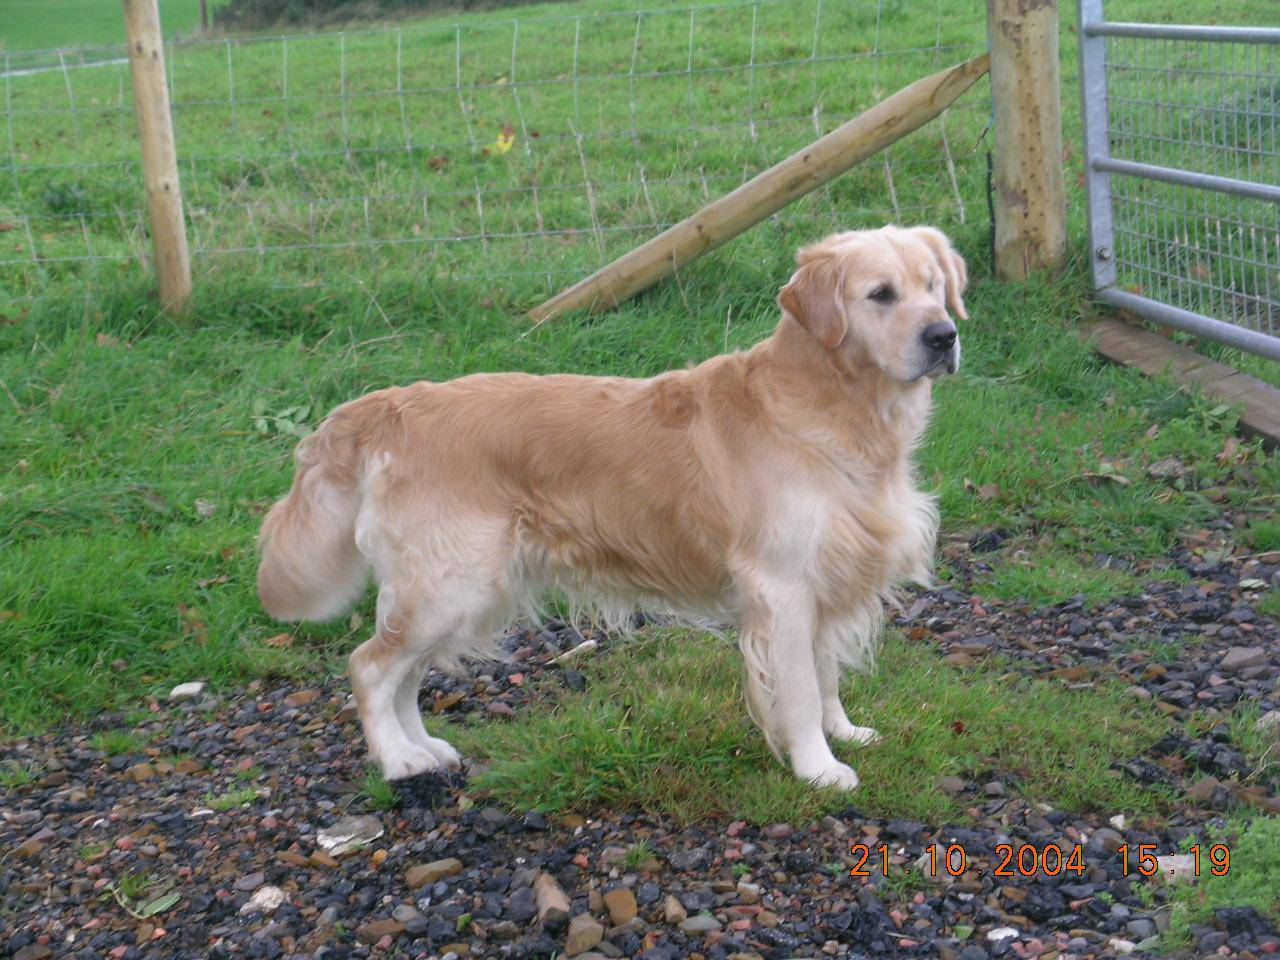

In [35]:
# Let's view an image from our dataset
from IPython.display import Image
Image(filename='train/febcab8eb2da444bf83336cffec7eb92.jpg')


### Getting images and their labels
Let's get a list of all of our image file pathnames.

In [36]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [37]:
filenames = ["train/" + fname + ".jpg" for fname in labels_csv['id'].values]
filenames[:10]

['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'train/001cdf01b096e06d78e9e5112d419397.jpg',
 'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'train/002a283a315af96eaea0e28e7163b21b.jpg',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [38]:
# check wheter number of filenames matches number of actual image filenames
import os
print("Number of filenames:", len(filenames))
print("Number of images in 'train' directory:", len(os.listdir('train')))

Number of filenames: 10222
Number of images in 'train' directory: 10222


Since we've now got our training image filepaths, let's prepare our labels.

In [39]:
import numpy as np
# Since we've now got our training image filepaths, let's prepare our labels.
# labels = np.array(labels_csv['breed'])
labels = labels_csv['breed']
if len(labels) == len(filenames): 
    print("Labels and filenames match!")
else:
    print("Labels and filenames do not match!")

Labels and filenames match!


In [40]:
# Find the unique dog breeds in the labels
unique_breeds = np.unique(labels)
# unique_breeds = set(labels)
print("Number of unique dog breeds:", len(unique_breeds))
print("Unique dog breeds:", unique_breeds)

Number of unique dog breeds: 120
Unique dog breeds: ['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrie

In [41]:
# Turn every label into an array of boolean values
boolean_labels = np.array([labels == breed for breed in unique_breeds]).T
boolean_labels.shape

(10222, 120)

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [42]:
# Setup X and y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [43]:
import ipywidgets as widgets
# Set number of images to use for experimenting 
NUM_IMAGES = widgets.IntSlider(
    value=4000,
    min=1000,
    max=10000,
    step=500,
    description='NUM_IMAGES:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
NUM_IMAGES

IntSlider(value=4000, continuous_update=False, description='NUM_IMAGES:', max=10000, min=1000, step=500)

In [44]:
# Let's split our data into training and validation sets
from sklearn.model_selection import train_test_split

np.random.seed(42)
# Take the first NUM_IMAGES images and their labels and
# split them into training and valdation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(
    X[:NUM_IMAGES.value], 
    y[:NUM_IMAGES.value], 
    test_size=0.2, 
    random_state=42
)
len(X_train), len(y_train), len(X_val), len(y_val)

(3200, 3200, 800, 800)

In [45]:
# Let's have a geeze athe the training data
X_train[:5], y_train[:5]

(['train/6338aedbf9de0ccbc208bdc99f8f2431.jpg',
  'train/0a3f1898556115d6d0931294876cd1d9.jpg',
  'train/49f0ef56406121db3ec89e2efa83aa03.jpg',
  'train/1e22e0538fb7aa3e9ffa72fc8244c182.jpg',
  'train/0c286c574ef09562c123dafe5ce6ac23.jpg'],
 array([[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, Fa

### Preprocessing images (turning images into tensors)
To preprocess our images, we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpeg file) into a tensor
4. Normalize the `image` tensor's pixel values to be between 0 and 1
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [46]:
# Convert to numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape 

(257, 350, 3)

In [47]:
image.max(), image.min()

(255, 0)

In [48]:
# turn image into tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  5

In [49]:
# Define image size
IMG_SIZE = 224

def process_image(image_path, imag_size=IMG_SIZE):
    # Read in the image
    image = tf.io.read_file(image_path)
    # Decode the image into a tensor with 3 color channels (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from integers (0-255) to floating-point numbers (0-1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to the desired size
    image = tf.image.resize(image, [imag_size, imag_size])
    return image

# Create a simple function to returtn a tuple of (image, label)
def get_image_label(image_path, label):
    image = process_image(image_path)
    return image, label

### Turning our data into batches
why turning our data into batches?
Let's say you are trying to process 10,000 images. in one go... they all might not fit into memory. So what we can do is break them up into smaller batches (say 32 images at a time) and process those smaller batches one at a time.
In order to use TensorFlow efficiently, we need our data in the form of Tensor tuples which look like this: (image, label).

Now we've got a way to turn our data into tuples of Tensors in the form of (image, label), i.e. `get_image_label`, let's use it to create batches of our training, validation and test data.

In [126]:
# Define the batch size, 32 is a good setattr
BATCH_SIZE = 32

# Create a function to turn our data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also acceptes test data as input (no labels).
    """
    # If the data is test dataset, we probably dont't have labels
    if test_data == True:
        print("Creating test data batches...")
        # Create a TensorFlow Dataset from X (image filepaths only)
        data = tf.data.Dataset.from_tensor_slices(tf.constant(X)) # only file paths (no labels)
        # Map the process_image function to every image filepath in the dataset
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data == True:
        print("Creating validationd data batches...")
        # Create a TensorFlow Dataset from X and y. Map get_image_label function
        dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                      tf.constant(y)))# labels
        dataset = dataset.map(get_image_label)
        # Batch the data
        dataset = dataset.batch(batch_size)
        return dataset
    else:
        print("Creating training data batches...")
        # Create a TensorFlow Dataset from (X, y) (image filepaths and labels)
        dataset = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                      tf.constant(y)))
        # Shuffle the data
        dataset = dataset.shuffle(buffer_size=len(X))
        # Map the get_image_label function to every (X, y) pair in the dataset
        dataset = dataset.map(get_image_label)
        # Batch the data
        dataset = dataset.batch(batch_size)
        return dataset

In [123]:
# Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)
val_data

Creating training data batches...
Creating validationd data batches...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [52]:
# Check out the difference between training and validation batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing Data Batches
Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [53]:
import matplotlib.pyplot as plt

# Create a function for viewing images in adata batch
def show_25_images(images, labels): 
    """_summary_
    Displays a plot of 25 images and their labels from a data batch.
    Args:
        images (_type_): _description_
        labels (_type_): _description_
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5,5,i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the train_test_split
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")         


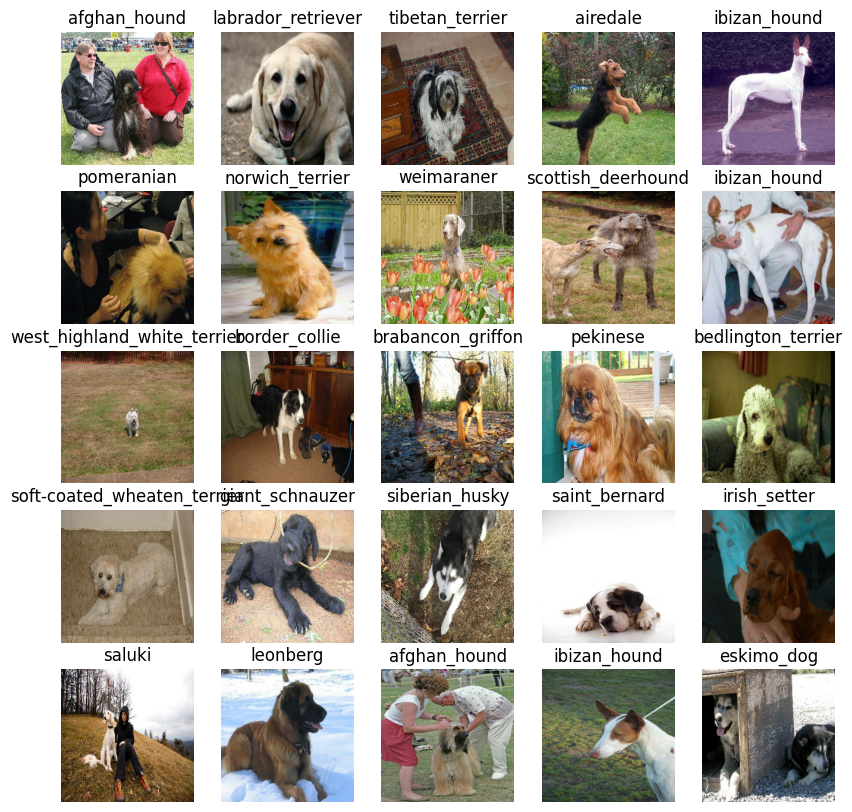

In [54]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

## Building a model
Before we build a model, there are a few things, we need to define
* The input shape ( our image shape, in the form of Tensors) to out model. 
* The output shape (image labels, in the form of Tensors) of our model. 
    * The URL of the model we want to use: go to [kaggle](https://www.kaggle.com/models) and pick a model. There is a guide to import it here.


In [69]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE =  len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

#### About mobilenet_v2
This model can be used with the `hub.KerasLayer` as follows.
Let's create a function which: 
* Takes the input shape, output shape and the model we've chosen as paramters. 
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that)
* Compiles the model (says it should be evaluated and improved).
* Builds the model ( tells the model the input shape it'll be getting)
* Returns the model.

In [70]:
import tensorflow_hub as hub
# tf.keras is using Keras 3.x (via tf.keras), but TensorFlow Hub's KerasLayer requires Keras 2.x compatibility. 
# So we use tf_keras here, instead of tf.keras
import tf_keras



def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with: ", model_url)
    # Setup model layers
    model = tf_keras.Sequential([
        hub.KerasLayer(model_url, trainable=False), # Layer 1 (input layer)
        tf_keras.layers.Dense(units=output_shape,
                              activation="softmax") # Layer 2 (output layer)
    ])
    # Compile the model
    model.compile(
        loss=tf_keras.losses.CategoricalCrossentropy(),
        optimizer=tf_keras.optimizers.legacy.Adam(),
        metrics=["accuracy"]
    )
    # Build the model
    model.build(input_shape)  # Batch input shape.

    return model

The output is a batch of logits vectors. The indices into the logits are the `num_classes = 1001` classes of the classification from the original training (see above). The mapping from indices to class labels can be found in the file at [download.tensorflow.org/data/ImageNetLabels.txt](download.tensorflow.org/data/ImageNetLabels.txt) (with class 0 for "background", followed by 1000 actual ImageNet classes).

The input `images` are expected to have color values in the range [0,1], following the common image input conventions. For this model, the size of the input images is fixed to `height x width = 224 x 224` pixels.

**What is `activation`?** in binary classification it is "sigmoid" and in multi-class classification it is "softmax" (betwen 0 and 1) 

In [71]:
model  = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


### Creating a callback 
callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving. 
We'll create two callbacks, one for Tensorboard which helps track our models progress and another for early stopping which prevents our model from training for too long. 

#### TensorBoard Callback
To setup, we need to do three things: 
1. Load the Tensorboard notebook extension 
2. Create a Tensorboard call back which is able to save logs to a dictionary and pass it to our model's `fit`() function.
3. Visualize our model training logs with the `%tensorboard` magic function (we'll do this after model training)

In [72]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [73]:
import datetime 

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Create a log directory for storing tensorboard logs
    logdir = os.path.join(os.getcwd(), "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    os.makedirs(logdir, exist_ok=True)
    return tf_keras.callbacks.TensorBoard(logdir)


### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving. 
[https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [74]:
# Crate early stopping callback
early_stopping = tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=3)

## Training a model (on subset of data)
Our first model is only going to train on 1000 images, to make sure everything is working.

In [75]:
NUM_EPOCHS = widgets.IntSlider(value=10, min=10, max=100, step=10)
NUM_EPOCHS

IntSlider(value=10, min=10, step=10)

In [76]:
# Check to make sure we are still running on a GPU
print("GPU Available!") if tf.config.list_physical_devices("GPU") else print("GPU NOT Availeble!!!")

GPU Available!


Let's create a function which trains a model.
* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs and the callbacks we'd like to use
* Return the model


In [77]:
# Build a function to traing and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data, 
              epochs=NUM_EPOCHS.value,
              validation_data=val_data,
              validation_freq=1,
              callbacks=[tensorboard, early_stopping])
    # Return the fitted model
    return model

# Fit the model to the data
model = train_model()


Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10


2025-12-28 22:18:49.945294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 58ms/step - loss: 2.5095 - accuracy: 0.4541 - val_loss: 1.0653 - val_accuracy: 0.7175
Epoch 2/10
100/100 [==============================] - 5s 54ms/step - loss: 0.5235 - accuracy: 0.8737 - val_loss: 0.8127 - val_accuracy: 0.7663
Epoch 3/10
100/100 [==============================] - 5s 54ms/step - loss: 0.2480 - accuracy: 0.9594 - val_loss: 0.7602 - val_accuracy: 0.7688
Epoch 4/10
100/100 [==============================] - 5s 54ms/step - loss: 0.1417 - accuracy: 0.9866 - val_loss: 0.7390 - val_accuracy: 0.7700
Epoch 5/10
100/100 [==============================] - 5s 54ms/step - loss: 0.0932 - accuracy: 0.9937 - val_loss: 0.7322 - val_accuracy: 0.7738
Epoch 6/10
100/100 [==============================] - 5s 55ms/step - loss: 0.0660 - accuracy: 0.9966 - val_loss: 0.7239 - val_accuracy: 0.7788
Epoch 7/10
100/100 [==============================] - 5s 54ms/step - loss: 0.0501 - accuracy: 0.9984 - val_loss: 0.7136 - val_accuracy: 0.7800
Epoch 8/1

**Question** it looks like our model is overfitting because it is performing far better on the training dataset than the validation dataset. What are the ways to prevent model overfitting in deep learning neural networks?

**Note:** Overfitting to begin with is a good thing! it means our model is learning!!!

### Checking the TensorBoard logs
The TensorBoard magic function (`%tensorboard`) will access the logs directory we created earlier and visualize its contents.

In [78]:
%tensorboard --logdir "/Users/sohail/workspace/mlearning/dog-breed-identification/logs/"

Reusing TensorBoard on port 6006 (pid 41910), started 19:50:58 ago. (Use '!kill 41910' to kill it.)

## Making and evaluating predictions using a trained model

In [79]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)

25/25 [==============================] - 1s 42ms/step


In [80]:
predictions.shape

(800, 120)

In [81]:
# First prediction
index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")


[5.1198458e-06 8.6761811e-06 3.3204196e-06 4.9960650e-05 1.7011538e-03
 1.7103098e-02 5.3040276e-06 4.7611471e-04 1.9759527e-05 5.7512909e-05
 3.0509244e-05 3.8814422e-04 2.0387026e-03 4.0570645e-05 6.5376430e-06
 4.3369100e-06 1.4168563e-05 2.4711320e-04 1.2360321e-06 4.9034734e-06
 1.0315481e-05 1.4742526e-04 1.0768251e-05 7.9520742e-06 5.2487571e-06
 8.0994005e-06 2.0104919e-06 2.1843411e-05 2.2255092e-06 4.1909084e-06
 2.2242944e-05 3.1218080e-06 1.7987197e-06 9.5270804e-07 2.2543139e-05
 1.4911924e-06 1.4967297e-05 8.2528795e-06 7.7356592e-05 1.9035301e-04
 1.0875619e-06 8.8885490e-06 9.3896616e-01 1.9976551e-05 1.6131024e-05
 3.5531230e-06 6.2171252e-06 8.5774882e-06 6.0040777e-05 1.9445060e-05
 1.3271664e-05 2.6022362e-06 3.6382330e-06 3.3278860e-02 1.1020254e-06
 6.7373687e-05 1.7698268e-06 5.1042102e-06 1.3564506e-06 3.9973911e-06
 5.8648507e-06 2.1040991e-05 4.4523134e-07 1.4646041e-04 1.4404952e-05
 4.2948144e-05 1.9007472e-06 7.8788444e-06 9.9291683e-06 2.1907051e-06
 8.919

Having the above functionality is great but we want to be able to do it at scale. 
And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [82]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
    """_summary_
        Turns an array of probabilities into a label
    Args:
        prediction_probabilities (_type_): _description_
    """
    return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'entlebucher'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels)

In [83]:
# Create a function to unbatch a bath dataset
def unbatchify(data):
    """_summary_
        Takes a batched dataset of (image, label) Tensors and returns separate arrays of images ans labels.
    Args:
        data (_type_): _description_
    """
    images = []
    labels = []

    # Loop through unbatched data
    for image, label in val_data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(get_pred_label(label))

    return images, labels

# Unbathify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

2025-12-28 22:20:50.035394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([[[0.7922948 , 0.8275889 , 0.8158242 ],
         [0.8123885 , 0.8476826 , 0.8359179 ],
         [0.79904485, 0.83433896, 0.82257426],
         ...,
         [0.8117648 , 0.8470589 , 0.8352942 ],
         [0.8117648 , 0.8470589 , 0.8352942 ],
         [0.8117648 , 0.8470589 , 0.8352942 ]],
 
        [[0.80639017, 0.8416843 , 0.8299196 ],
         [0.8028001 , 0.83809423, 0.8263295 ],
         [0.803159  , 0.8384531 , 0.8266884 ],
         ...,
         [0.81568635, 0.85098046, 0.83921576],
         [0.81568635, 0.85098046, 0.83921576],
         [0.81568635, 0.85098046, 0.83921576]],
 
        [[0.80020356, 0.8354977 , 0.823733  ],
         [0.8046996 , 0.8399937 , 0.828229  ],
         [0.80884004, 0.84413415, 0.83236945],
         ...,
         [0.81818986, 0.853484  , 0.84171927],
         [0.81818986, 0.853484  , 0.84171927],
         [0.81818986, 0.853484  , 0.84171927]],
 
        ...,
 
        [[0.7951923 , 0.8108786 , 0.806957  ],
         [0.8004999 , 0.8161862 , 0.81226

Now We've got ways to get: 
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visualise.

We will create a function which:
* Takes an array of prediction probs, an array of truth labels, and an array of images and integers.
* Convert the prediction probs to a predicted label
* Plot the predicted label, its predicted prob, the truth label and the target image on a single plot.

In [84]:
def plot_pred(prediction_probabilities, labels, images, n=0):
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Change the color of the title depending on if the prediction is right or wrong
    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    # Change plot title to be predicted, probability of prediction and truth label
    plt.title("{} {:2.0f}% {}".format(pred_label, np.max(pred_prob)*100, true_label), color=color)

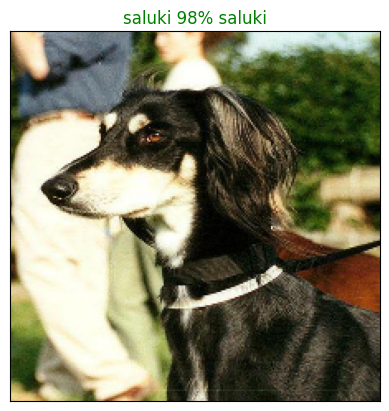

In [91]:
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=1)

Now we have got one funciton to visualize our models top prediction, let's make another to view our top 10 predictions.

This function will: 
* Take an input of prediction probs array and a ground truth array and an integer
* Find the prediction using `get_pred_label()`
* Find the top 10:
    * Predition probs indexes
    * Prediction probs values
    * prediction labels
* Plot the top 10 preds probs values and labels, coloring the true label green

In [86]:
def plot_pred_conf(prediction_probabilities, labels, n=0):
    
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # Get the pred label
    pred_label = get_pred_label(pred_prob)

    # Find the top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

    # Find the top 10 prediction confidence values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Find the top 10 prediction labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                       top_10_pred_values, 
                       color="grey")

    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")

    # Change color of true label
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    else:
        pass

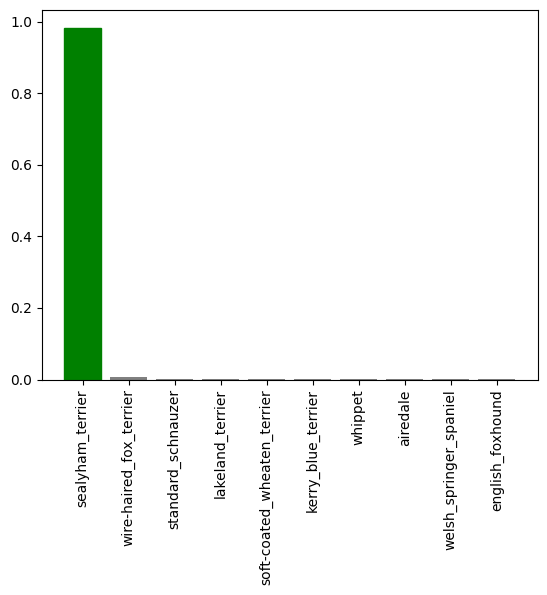

In [93]:
plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=3)

## Saving and reloading a trained model

In [98]:
# Create a function to save a model
def save_model(model, suffix=None):
    """_summary_
    Saves a given model in a models directory and appends a suffix (string)
    Args:
        model (_type_): _description_
        suffix (_type_, optional): _description_. Defaults to None.
    """
    # Create a model directory pathname with current train_images
    modeldir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
    model_path = modeldir + "-" + suffix + ".h5"
    print(f"Saving model to: {model_path}")
    model.save(model_path)
    return model_path

# Create a function to load a model
def load_model(model_path):
    print(f"Loading saved model from: {model_path}")
    model = tf_keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
    return model


In [ ]:
# Save our model trained on 100 images
save_model(model, suffix="1000-images-mobilnetv2-Adam")

In [99]:
# Load a trained model
loaded_1000_image_model = load_model("models/20251228-22461766961998-1000-images-mobilnetv2-Adam.h5")

Loading saved model from: models/20251228-22461766961998-1000-images-mobilnetv2-Adam.h5


In [100]:
# Evaluate the presaved model
model.evaluate(val_data)

25/25 [==============================] - 1s 43ms/step - loss: 0.7271 - accuracy: 0.7825


[0.7270700931549072, 0.7825000286102295]

In [101]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

25/25 [==============================] - 1s 43ms/step - loss: 0.7271 - accuracy: 0.7825


[0.7270700931549072, 0.7825000286102295]

## Training a big dog model (On the full data)

In [102]:
# Create a data batch with the full data set
full_data = create_data_batches(X,y)
full_data

Creating training data batches...


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [109]:
# Create a model
full_model = create_model()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [110]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf_keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [111]:
# FIt the full model to the full data
full_model.fit(x=full_data, epochs=NUM_EPOCHS.value,
               callbacks=[full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 15s 44ms/step - loss: 1.3391 - accuracy: 0.6731
Epoch 2/100
320/320 [==============================] - 14s 43ms/step - loss: 0.4058 - accuracy: 0.8796
Epoch 3/100
320/320 [==============================] - 14s 44ms/step - loss: 0.2360 - accuracy: 0.9354
Epoch 4/100
320/320 [==============================] - 14s 44ms/step - loss: 0.1557 - accuracy: 0.9600
Epoch 5/100
320/320 [==============================] - 14s 44ms/step - loss: 0.1060 - accuracy: 0.9775
Epoch 6/100
320/320 [==============================] - 14s 44ms/step - loss: 0.0774 - accuracy: 0.9874
Epoch 7/100
320/320 [==============================] - 14s 44ms/step - loss: 0.0586 - accuracy: 0.9911
Epoch 8/100
320/320 [==============================] - 14s 44ms/step - loss: 0.0461 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 14s 44ms/step - loss: 0.0379 - accuracy: 0.9959
Epoch 10/100
320/320 [==============================] - 14s 44ms/step - l

In [112]:
# Save our model trained on 100 images
save_model(model, suffix="full-image-set-mobilnetv2-Adam")

Saving model to: models/20251229-00381766968728-full-image-set-mobilnetv2-Adam.h5


/Users/sohail/workspace/mlearning/dog-breed-identification/.venv/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'models/20251229-00381766968728-full-image-set-mobilnetv2-Adam.h5'

## Making predictions with the full model
Since our model has been trained on images in the form of Tensor batches, to make predictions with it, we need to ensure our input images are in the same format.

Luckily, we created a function earlier which can turn our image filepaths into Tensor batches, `create_data_batches()`. So let's use that to turn our validation image filepaths into Tensor batches and make predictions on them with our full model.

To make predictions on the testing data, we'll:
* Get the test image filenames
* Convert the filenames into test data batches using `create_data_batches()`
* Make predictions array by passing the test data batches to the full model's `predict()` function


In [114]:
# Load test images filenames
test_path = "test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
len(test_filenames), test_filenames[:10]

(10357,
 ['test/266490a2b053a4a3bf68e779f28fb5a9.jpg',
  'test/dae9fd18836d8df20989ef0101771d4b.jpg',
  'test/079a40f22b0fad9a66f76797b62bb930.jpg',
  'test/ab8462f9a501d362041d47582fddc9ad.jpg',
  'test/8895089b432e020cc42e6262b5a1c2dd.jpg',
  'test/985ae7fc271ac4a0d131e546c0f95bb6.jpg',
  'test/77c1ab99cffb817d54fb14f229aeb118.jpg',
  'test/ad7e50abca9b7c6a88b63946c5bbe493.jpg',
  'test/d61a09cecf56666cdb315ebce4b93c43.jpg',
  'test/cb120c57904e8c0694bbe259c58a873c.jpg'])

In [127]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data=True)
test_data

Creating test data batches...


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

**Note:** Calling `predict()` on our full model may take a while depending on the size of the test dataset and the hardware you're using.

In [128]:
# Make predictions on the test data
test_predictions = full_model.predict(test_data, verbose=1)

324/324 [==============================] - 14s 43ms/step


In [129]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for submission to Kaggle
To prepare our test dataset predictions for submission to Kaggle, we need to create a submission file which contains:
* An `id` column with the image filenames (without the .jpg extension)
* A column for each dog breed with the predicted probability for each breed for each image  

To get the data in this format, we need to:
* Create a Pandas DataFrame with the required columns
* Save the DataFrame to a CSV file

In [130]:
# Create a pandas DataFrame for submission to Kaggle
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df["id"] = [os.path.basename(fname).split(".")[0] for fname in test_filenames]

# Add the prediction probabilities to the DataFrame
for i, breed in enumerate(unique_breeds):
    preds_df[breed] = test_predictions[:, i]

preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,266490a2b053a4a3bf68e779f28fb5a9,1.735951e-12,8.043795e-09,1.845752e-11,2.533053e-09,8.041685e-15,1.203667e-08,1.289914e-15,1.035990e-14,1.292416e-06,...,8.628366e-13,3.592241e-11,6.323368e-07,3.432423e-08,1.174345e-09,5.548593e-16,4.181809e-12,3.009856e-08,4.646707e-13,3.897467e-15
1,dae9fd18836d8df20989ef0101771d4b,2.719948e-03,1.278173e-03,3.398861e-07,5.900750e-08,2.453473e-08,4.447767e-09,5.103483e-04,9.173787e-12,5.788313e-10,...,3.045281e-09,4.719290e-08,8.985744e-10,6.801416e-05,3.072532e-06,9.460959e-14,1.799108e-07,1.996508e-09,4.223244e-07,2.452835e-09
2,079a40f22b0fad9a66f76797b62bb930,9.109250e-09,6.725777e-13,1.333374e-14,2.093185e-12,1.739135e-12,2.724029e-13,1.228095e-13,9.737427e-13,3.003428e-14,...,1.149096e-14,3.443402e-14,7.479480e-14,3.767427e-12,2.919249e-12,1.209573e-14,1.008475e-15,8.205547e-15,4.124602e-14,2.253101e-14
3,ab8462f9a501d362041d47582fddc9ad,1.627024e-12,1.200273e-10,2.331281e-15,7.171547e-10,6.415105e-15,3.722686e-10,2.168774e-11,5.490247e-16,1.517120e-12,...,1.314577e-11,2.611008e-13,1.296850e-12,3.113567e-10,3.339702e-13,1.704945e-10,2.047640e-11,4.159229e-13,7.771814e-16,2.460669e-09
4,8895089b432e020cc42e6262b5a1c2dd,5.201760e-13,7.003405e-13,1.007225e-10,4.292508e-14,7.364979e-11,3.506505e-10,7.202615e-09,1.423397e-05,6.674828e-08,...,2.041011e-11,2.966293e-10,1.836480e-11,2.537583e-13,3.313253e-12,7.820404e-10,7.287135e-11,3.002525e-09,7.217202e-10,1.097454e-13


In [131]:
# Save the predictions DataFrame to a CSV file
preds_df.to_csv("dog_breed_predictions_kaggle_format.csv", index=False)

## Making predictions on custom images
To make predictions on our own images, we need to:
* Get some dog images (from the web or your own collection)
* Preprocess the images to be in the same format as the data our model was trained on with `test_data` parameter to `True`
* Pass the images to our trained model's `predict()` function model our preprocessed images to get prediction probabilities
* Convert the prediction probabilities to labels and visualize the predictions using our `plot_pred` function


In [134]:
# Load test images filenames
test_path = "my-dog-photos/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
# Create test data batches
my_test_data = create_data_batches(test_filenames, test_data=True)
# Make predictions on the test data
my_test_predictions = full_model.predict(my_test_data, verbose=1)


Creating test data batches...
1/1 [==============================] - 0s 24ms/step


In [137]:
# Get Labels
labels = [get_pred_label(pred) for pred in my_test_predictions]
labels

['german_shepherd', 'english_foxhound', 'chow']

In [138]:
test_filenames


['my-dog-photos/Unknown3.jpeg',
 'my-dog-photos/Unknown2.jpeg',
 'my-dog-photos/Unknown.jpeg']

## Ways to improve our model

1. Trying another model from TensorFlow Hub - Perhaps a different model would perform better on our dataset. One option would be to experiment with a different pre-trained model from TensorFlow Hub or look into the tf.keras.applications module.

2. **Data augmentation** - Take the training images and manipulate (crop, resize) or distort them (flip, rotate) to create even more training data for the model to learn from. Check out the TensorFlow images documentation for a whole bunch of functions you can use on images. A great idea would be to try and replicate the techniques in this example cat vs. dog image classification notebook for our dog breeds problem.

3. **Fine-tuning** - The model we used in this notebook was directly from TensorFlow Hub, we took what it had already learned from another dataset (ImageNet) and applied it to our own. Another option is to use what the model already knows and fine-tune this knowledge to our own dataset (pictures of dogs). This would mean all of the patterns within the model would be updated to be more specific to pictures of dogs rather than general images.